In [1]:
import os
import math
import numpy as np
from voice_utils import *
from IPython.display import display, Audio
from matplotlib import pyplot
from librosa.util import frame as create_windows
from librosa import note_to_hz
from scipy.ndimage import uniform_filter1d

In [2]:
sample_rate, audio = load_audio('/audio/Lopez Island.wav')
display(Audio(data=audio, rate=sample_rate))

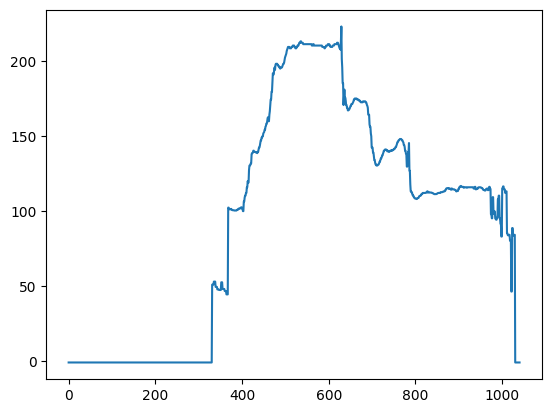

In [3]:
reaper_init(sample_rate, do_highpass=True, do_hilbert=True)    
freqs = reaper_process(audio)
pyplot.plot(freqs)
pyplot.show()

In [14]:
window_length = 512
osamp = 256
hop_length = window_length // osamp
windows = create_windows(x=audio, frame_length=window_length, hop_length=hop_length, axis=0) * np.hanning(window_length)

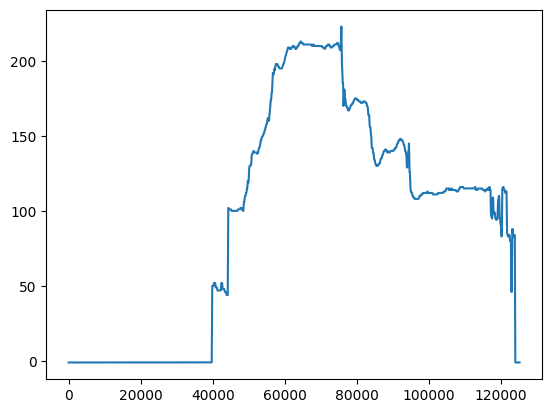

In [15]:
resampled_freqs = tuner_upsample_linear(freqs, len(windows))
pyplot.plot(resampled_freqs)
pyplot.show()

In [16]:
c_major = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
min_octave = -8
max_octave = 8

scale = []
for octave in range(min_octave, max_octave):
    for note in c_major:
        scale.append(note_to_hz(note + str(octave)))

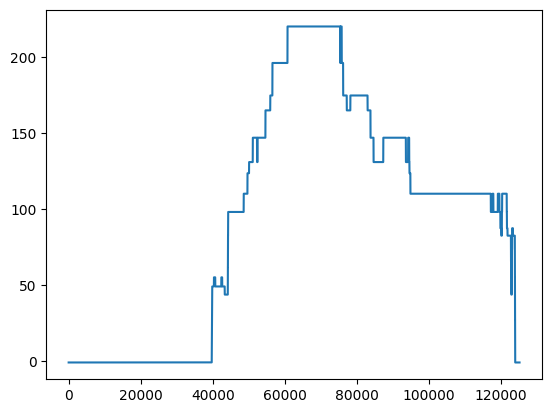

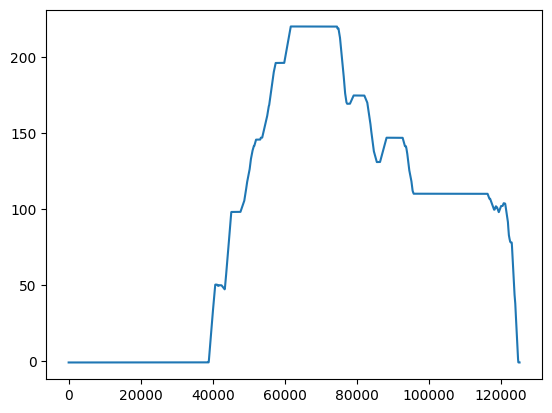

In [17]:
smoothing_enabled = True
smoothness = 70

# Determine which note each window should be shifted to
target_freqs = []
for freq in resampled_freqs:
    if freq <= 0:
        target_freqs.append(freq)
    else:
        closest_note_freq = 0
        closest_distance = float('inf')
        for note_freq in scale:
            distance = abs(np.log(note_freq) - np.log(freq))
            if distance < closest_distance:
                closest_distance = distance
                closest_note_freq = note_freq
        target_freqs.append(closest_note_freq)

# Smooth the target frequencies to eliminate chop
smooth_freqs = target_freqs
if smoothing_enabled:
    smooth_freqs = uniform_filter1d(target_freqs, int(len(target_freqs) / smoothness))
    
        
pyplot.plot(target_freqs)
pyplot.show()

pyplot.plot(smooth_freqs)
pyplot.show()

In [18]:
shift_multipliers = []
for original, target in zip(resampled_freqs, smooth_freqs):
    if original <= 0:
        shift_multipliers.append(1)
    else:
        shift_multipliers.append(target / original)

In [19]:
smb_init(window_length, sample_rate, osamp)
new_windows = []
for window, shift_multiplier in zip(windows, shift_multipliers):
    new_window = smb_process_window(window, shift_multiplier)
    new_windows.append(new_window)

In [20]:
shifted_audio = np.zeros(len(windows) * hop_length + window_length).astype(np.int16)
for i in range(len(windows)):
    window = new_windows[i]
    for j in range(len(window)):
        index = i * hop_length + j
        shifted_audio[index] += window[j]

In [21]:
shifted_freqs = reaper_process(shifted_audio)

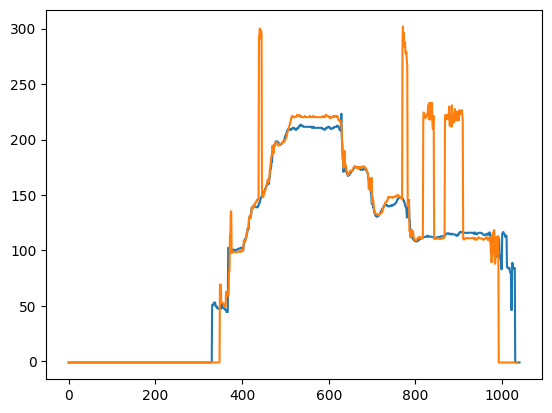

In [24]:
pyplot.plot(freqs)
pyplot.plot(shifted_freqs)
pyplot.show()

In [25]:
display(Audio(data=shifted_audio, rate=sample_rate))